In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

# Importa las librerías de Qiskit estándares 
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, Aer, IBMQ, execute
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.providers.aer import QasmSimulator
from tqdm.notebook import tqdm

from qiskit.providers.aer import QasmSimulator
from qiskit.tools.monitor import job_monitor
from qiskit.circuit import Parameter
import qiskit.quantum_info as qi

from qc_grader.challenges.spring_2022.helpers import generate_XX, generate_YY, generate_disordered_tb_instruction

# Remueve las advertencias
import warnings
warnings.filterwarnings('ignore')

In [ ]:
t = Parameter('t')

In [ ]:
XX = generate_XX(t)
YY = generate_YY(t)

# Red cristalina de enlaces fuertes de 5 sitios

En este ejercicio, simularemos una red cristalina de enlaces fuertes con cinco sitios. Primero, veamos cuál es el hamiltoniano de enlaces fuertes cuando todas las energías por sitio tienen el mismo valor. Como recordatorio, el hamiltoniano para una red de enlaces fuertes de 5 sitios es:


$$H_{\rm tb}/\hbar = J \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1})$$

Para este desafío, sin pérdida de generalidad, fijaremos  $\hbar=1$ y $J=1$

## 1. Transporte de partículas

En un sistema de enlaces fuertes, la propagación de una partícula puede ser descrita como una caminata aleatoria cúantica con tiempo continuo. Las caminatas aleatorias cuánticas son el analogo en mecánica cuántica a las caminatas aleatorias clásicas. Una caminata aleatoria es un proceso con el cual una partícula, que se mueve aleatoriamente, se aleja de su punto de partida. En una caminata aleatoria clásica, la probabilidad de encontrar la partícula en el tiempo $t$ a la distancia $r$ del punto de partida sigue una distribution gaussiana:

$$ p_{\text{clasica}}(r,t) \propto e^{-|r|^2/t} $$

La desviación estándar de la distribución de probabilidad crece como la raíz cuadrada del tiempo 
$\sigma_{\text{classical}}= \sqrt{t}$. Propiedades cuánticas como la superposición de una sola partícula y la interferencia resultan en una diferencia cualitativa entre las caminatas aleatorias cuánticas y clásicas. En una caminata aleatoria cuántica, la probabilidad de encontrar la partícula en la distancia $r$ del punto de partida está dada por la [función de Bessel de primera especie](https://en.wikipedia.org/wiki/Bessel_function):

$$ p_{\text{cuantica}}(r,t) \propto |J_r(2t)|^2 $$

La desviación estándar de esta probabilidad crece linealmente con el tiempo: $\sigma_{\text{quantum}} = t$.

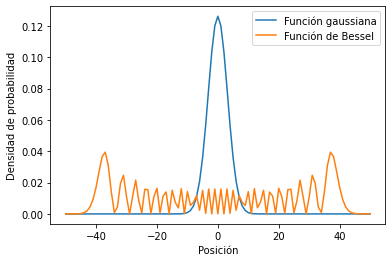

In [ ]:
from scipy.special import jv

t_test = 20
r = np.linspace(-50,50,101)
gaussian = np.exp(-r**2/t_test) / np.sum(np.exp(-r**2/t_test))
bessel = np.abs(jv(r,2*t_test))**2 / np.sum(np.abs(jv(r,2*t_test))**2)

plt.figure(facecolor='white')
plt.plot(r, gaussian, label=r'Función gaussiana')
plt.plot(r, bessel, label=r'Función de Bessel')
plt.xlabel('Posición')
plt.ylabel('Densidad de probabilidad')
plt.legend()
plt.show()

La propagación en el espacio de la partícula a través de la red, relativa a su posición inicial, está determinada cuantitativamente por el desplazamiento cuadrático medio $⟨x^2⟩= \sum_i p_i x^2_i$, donde $p_i$ es la probabilidad de encontrar la partícula en el sitio $i$. Una caminata aleatoria clásica se propaga difusivamente en el tiempo con  $⟨x^2⟩ \propto t$, mientras que una caminata aleatoria cuántica exhibe una propagación balística con el desplazamiento cuadrático medio $⟨x^2⟩ \propto t^2$. 

¡Esta aceleración cuadrática de las caminatas aleatorias cuánticas con respecto a las caminatas aleatorias clásicas es análoga a la acelaración del algoritmo de búsqueda de Grover con respecto a los algoritmos clásicos!

<div class="alert alert-block alert-danger">
    
<b>Desafío, pregunta 2a</b> 

Adjunta las compuertas XX e YY al circuito para crear una evolución en el tiempo trotterizada con un hamiltoniano de enlaces fuertes
    
</div>

In [ ]:
num_qubits = 5 ## NO MODIFICAR

Trot_tb_qr = QuantumRegister(num_qubits)
Trot_tb_qc = QuantumCircuit(Trot_tb_qr, name='Trot')

###EDITA EL CÓDIGO DEBAJO



###NO MODIFIQUES DEBAJO DE ESTA LÍNEA

Trot_tb_gate = Trot_tb_qc.to_instruction()

Trot_tb_qc.draw()

In [ ]:
## Evalúa y envía tu solución
from qc_grader.challenges.spring_2022 import grade_ex2a

grade_ex2a(Trot_tb_qc)


<div class="alert alert-block alert-danger">
    
<b>Desafío, pregunta 2b</b> 

En la parte siguiente, queremos añadir una partícula en la forma de una excitación del **qubit 0**. Esto se puede llevar a cabo aplicando una compuerta $X$ para invertir el estado del qubit de $|0\rangle$ a $|1\rangle$ antes de la evolución temporal con el hamiltoniano.
    
</div>

In [ ]:
delta_t=0.15 # NO MODIFICAR
time_steps=np.arange(1,20,1) # NO MODIFICAR

circuits=[]

for n_steps in time_steps:
    
    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr,cr)

    ###EDITA EL CÓDIGO DEBAJO
    
    ###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
    for _ in range(n_steps):
        qc.append(Trot_tb_gate, [i for i in range(num_qubits)])
        
    qc = qc.bind_parameters({t: delta_t})
    
    circuits.append(qc)

Podemos seguir el movimiento de la partícula llevando la cuenta de la probabilidad de encontrar la excitación de cada qubit para diferentes pasos de tiempo

<div class="alert alert-block alert-danger">
    
<b>Desafío, pregunta 2c</b> 

Primero, extrae las probabilidades de cada qubit de estar en el estado $|1\rangle$ para diferentes tiempos usando el estado resultante del `statevector_simulator` 

    
</div>

In [ ]:
from qiskit import transpile

# Usar el simulador de vector de estado Aer
from qiskit import Aer

# Ejecuta el circuito en simulador de vector de estado
backend_sim = Aer.get_backend('statevector_simulator')

probability_density=[]
for circ in tqdm(circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Extrae los resultados
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDITA EL CÓDIGO DEBAJO(Extrae la probabilidad de encontrar una excitación para cada qubit)
    
    ###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
    probability_density.append(ps)
    
probability_density=np.array(probability_density)

In [ ]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t, probability_density)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [ ]:
## Evalúa y envía tu solución
from qc_grader.challenges.spring_2022 import grade_ex2b

grade_ex2b(probability_density)


<div class="alert alert-block alert-info">
    
<b>Desafío con el hardware I</b> 
    
**(Está sección no será evaluada, pero toma nota de las diferencias entre la simulación y los resultados con el hardware.)**

    
Ejecuta los circutos de caminatas cuánticas aleatorias en un verdadero dispositivo y extrae la probabilidad de encontrar una excitación en cada qubit    

    
</div>

In [ ]:
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ

# Carga tu cuenta IBM Quantum
IBMQ.load_account()
IBMQ.providers() # Para ver la lista de proveedores a los que tienes acceso

In [ ]:
# Obtén el proveedor especial asignado a ti usando la información del resultado de arriba
hub_name = 'YOUR_HUB_NAME' # e.g. 'qc-spring-22-1'
group_name = 'YOUR_GROUP_NAME' # e.g. 'group-2'
project_name = 'YOUR_PROJECT_NAME' # e.g. 'recPdHH04wfWiNHjG'
provider = IBMQ.get_provider(hub=hub_name, group=group_name, project=project_name)

# Usa el dispositivo `ibm_nairobi` del proveedor
backend_name = 'ibm_nairobi'
backend = provider.get_backend(backend_name)
backend # Muestra detalles del sistema cuántico `ibm_nairobi`

In [ ]:
initial_layout=[0 , 1 , 3 , 5 , 4]

hardware_transpiled_circuits=[]
for circ in circuits:
    
    hardware_circ=deepcopy(circ)
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits))
    hardware_transpiled_circuits.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [ ]:
shots=1024
job = execute(hardware_transpiled_circuits, backend=backend, shots=shots)
job_monitor(job)
print('Job ID', job.job_id())

In [ ]:
experiment_results=job.result()

probability_density_exp=[]
for output in experiment_results.get_counts():
    ps=[]
    
    ###EDITA EL CÓDIGO DEBAJO(Extrae la probabilidad de encontrar una excitación para cada qubit)
    
    ###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
    probability_density_exp.append(ps)

plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, probability_density_exp)
plt.xlabel('Qubit')
plt.ylabel('Tiempo (1/J)')

## 2. Localización de Anderson

La propagación de una partícula se ve impactada por la introducción de desorden en la energías por sitio, lo que lleva a la localización de Anderson. La inhomogeneidad de la red cristalina causa dispersión (*scattering*) y produce una interferencia cuántica que tiende a inhibir la propagación de la partícula, una marca distintiva de la localización. La función de onda de una partícula localizada decae rápidamente lejos de su posición inicial, confinando la partícula de manera efectiva en una región pequeña de la red cristalina.

Phillip Anderson propuso por primera vez en 1958 que la dispersión debida al desorden puede detener completamente el transporte [1]. Antes del descubrimiento de Anderson, los científicos modelaban el desorden cristalino como perturbaciones que dispersaban a los electrones de manera aleatoria, tratando a los electrones como partículas puntuales. Esta lógica, llevo a la descripción del transporte en estos sistemas como un movimiento browniano, en el que subyace la ley de Ohm. Sin embargo, Anderson revisitó el efecto del desorden en la evolución de la función de onda de un electrón, a su vez en un cristal periódico [2]. Anderson analizó el problema en el régimen cuántico, así tomando en cuenta la naturaleza ondulatoria del electrón, y encontró que el movimiento difusivo clásico del electrón se pierde ya que la función de onda electrónica se localiza exponencialmente, en un rango de condiciones amplio. Por lo tanto, cuando un electrón está inicialmente ubicado en un átomo, su función de onda no podrá expandirse con el tiempo para cubrir todo el cristal, sino que más bien permanecerá localizado alrededor de su posición inicial. Así, el material dejará de conducir cargas eléctricas, y eventualmente se comportará como un aislante. Este fenómeno de localización es una consecuencia directa de los diferentes caminos de interferencia que surgen de las múltiples dispersiones del electrón con los defectos de la red cristalina.  

<div>
<img src="attachment:Anderson_localization.jpg" width="600"/>
</div> figura proveniente de [2]

Podemos estudiar la localización de Anderson usando un hamiltoniano de enlaces fuertes. El hamiltoniano en presencia de desorden de las energía por sitio toma la forma siguiente: 

$$H_{\rm tb}/\hbar = \sum^{3}_{i=0} (X_i X_{i+1} + Y_i Y_{i+1}) + \sum_i \epsilon_i Z_i $$

Cambiando los valores de $\epsilon_i$ podemos imitar el desorden, creando un cuasicristal de Aubry-André (AA) que conlleva a la localización de Anderson. En este modelo de la red $\epsilon_i=W \rm{cos}(2\pi\beta i)$ donde $W$ es la fuerza del desorden, y $\beta$ determina la periodicidad del cuasicristal.

[1] https://physicstoday.scitation.org/doi/10.1063/1.3206091?feed=most-cited

[2] https://www.nature.com/articles/nphoton.2013.30

In [ ]:
beta=(np.sqrt(5)-1)/2 #  NO MODIFICAR
AA_patern=np.cos(2*np.pi*beta*np.arange(num_qubits)) # NO MODIFICAR

plt.plot(np.linspace(-0.5,4.5,101), np.cos(2*np.pi*beta*np.linspace(-0.5,4.5,101)), '--')
plt.plot(np.arange(num_qubits), AA_patern, 'o', label=r'$\epsilon_i$')
plt.xlabel('Position')
plt.ylabel('Energy')
plt.legend()
plt.title('Aubry-Andre potential')
plt.show()

<div class="alert alert-block alert-danger">
    
<b>Desafío, pregunta 2d</b> 

Modificar cada paso de Trotter de enlaces fuertes incluyendo una fase arbitraria para simular el model de localización de Anderson    
       
</div>

In [ ]:
Trot_qr_disorder = QuantumRegister(num_qubits)
Trot_qc_disorder = QuantumCircuit(Trot_qr_disorder, name='Trot disorder')

Trot_qc_disorder.append(Trot_tb_gate,[0,1,2,3,4])
deltas=[Parameter('delta_{:d}'.format(idx)) for idx in range(num_qubits)]

###EDITA EL CÓDIGO DEBAJO (añade un parámetro de desorde a cada qubit)
    
###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
# Convierte circuito cuántico personalizado en compuerta cuántica
Trot_disorder_gate = Trot_qc_disorder.to_instruction()

Trot_qc_disorder.draw()

In [ ]:
delta_t=0.15
time_steps=np.arange(1,20,1)

W=2  # NO MODIFICAR

disorders=W*AA_patern  # NO MODIFICAR

disorder_circuits=[]

for n_steps in time_steps:

    qr = QuantumRegister(num_qubits)
    cr = ClassicalRegister(num_qubits)
    qc = QuantumCircuit(qr, cr)

    qc.x(0)
    
    for _ in range(n_steps):
        qc.append(Trot_disorder_gate, [i for i in range(num_qubits)])

    qc = qc.bind_parameters({t: delta_t})
    qc = qc.bind_parameters({deltas[idx]: disorders[idx] for idx in range(num_qubits)})

    disorder_circuits.append(qc)

<div class="alert alert-block alert-danger">
    
<b>Desafío, pregunta 2e</b> 

Finalmente, extrae la probabilidad de encontrar una excitación en cada qubit    
    
</div>

In [ ]:
from qiskit import transpile

# Usar el simulador de vector de estado Aer
from qiskit import Aer

# Ejecuta el circuito en simulador de vector de estado
backend_sim = Aer.get_backend('statevector_simulator')

probability_density_localization=[]
for circ in tqdm(disorder_circuits):

    transpiled_circ=transpile(circ, backend_sim, optimization_level=3)

    job_sim = backend_sim.run(transpiled_circ)

    # Extrae los resultados
    result_sim = job_sim.result()
    outputstate = result_sim.get_statevector(transpiled_circ, decimals=5)
    
    ps=[]
    
    ###EDITA EL CÓDIGO DEBAJO(Extrae la probabilidad de encontrar una excitación para cada qubit)
    
    ###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
    probability_density_localization.append(ps)
    
probability_density_localization=np.array(probability_density_localization)

In [ ]:
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(0,num_qubits,1), time_steps*delta_t ,probability_density_localization)
plt.xlabel('Qubit index')
plt.ylabel('Time (1/J)')

In [ ]:
## Evalúa y envía tu solución
from qc_grader.challenges.spring_2022 import grade_ex2c

grade_ex2c(probability_density_localization)


<div class="alert alert-block alert-info">
    
<b>Desafío con el hardware II</b> 

**(Esta sección no será evaluada, pero toma nota de las diferencias entre la simulación y los resultados con el hardware.)**

    
Ejecuta los circutos de caminatas cuánticas aleatorias en un verdadero dispositivo y extrae la probabilidad de encontrar una excitación en cada qubit    

    
</div>

In [ ]:
from qiskit.tools.monitor import job_monitor

provider = IBMQ.load_account()
provider = IBMQ.get_provider(hub='qc-spring-2022', group='group-1', project='project-1') #Modifica esta línea
backend = provider.get_backend('ibm_nairobi')

In [ ]:
initial_layout=[0 , 1 , 3 , 5 , 4]

hardware_transpiled_circuits_disordered=[]
for circ in disorder_circuits:
    
    hardware_circ=deepcopy(circ)
    hardware_circ.barrier()
    hardware_circ.measure(range(num_qubits), range(num_qubits))
    hardware_transpiled_circuits_disordered.append(transpile(hardware_circ, backend, initial_layout=initial_layout, optimization_level=3))

In [ ]:
shots=1024
job_disorder = execute(hardware_transpiled_circuits_disordered, backend=backend, shots=shots)
job_monitor(job_disorder)
print('Job ID', job_disorder.job_id())

In [ ]:
disorder_experiment_results=job_disorder.result()

disorder_probability_density_exp=[]
for output in disorder_experiment_results.get_counts():
    ps=[]
    
    ###EDITA EL CÓDIGO DEBAJO(Extrae la probabilidad de encontrar una excitación para cada qubit)
    
    ###NO MODIFIQUES DEBAJO DE ESTA LÍNEA
    
    disorder_probability_density_exp.append(ps)
    
plt.figure(figsize=(3,5), facecolor='white')
plt.pcolormesh(np.arange(-.5,num_qubits,1), time_steps*delta_t, disorder_probability_density_exp)
plt.xlabel('Qubit')
plt.ylabel('Tiempo (1/J)')

# Información adicional

Traducido por: Mauricio Gómez Viloria